# Monitor de recesión

<div style="nosxt-align:cennosr; font-size:26px; color:green;">Indicadores de recesión.</div>

Si no compartimos el conocimiento no sirve para nada. [Michio Kaku](https://www.younuestrobe.com/watch?v=6rDxlolYUQw)


**Descarga de cotizaciones.**  
Para obtener datos históricos de precios, puedes:

Descargarlos directamente desde las gestoras de los fondos.
Utilizar plataformas públicas como Yahoo Finance mediante la librería yfinance.
yfinance es una herramienta popular en análisis financiero que facilita el acceso a datos históricos considerados de dominio público. Sin embargo, estos datos pueden presentar pequeñas diferencias con respecto a las fuentes oficiales. Por ello, para decisiones críticas, siempre se recomienda contrastar la información con la documentación oficial de la gestora.

⚠️ **Precauciones.**
Este proyecto utiliza yfinance (con licencia bajo la [Apache License 2.0](https://www.apache.org/licenses/LICENSE-2.0).
), una interfaz para descargar datos financieros desde Yahoo Finance. Ten en cuenta lo siguiente:

Los datos descargados son exclusivamente para uso personal.
No está permitido redistribuirlos o venderlos.
Su uso en contextos educativos o sin ánimo de lucro suele ser aceptable, siempre que se cumplan estas condiciones.
Evita realizar peticiones excesivas o abusivas que puedan violar los términos de uso del servicio.



In [ ]:
# MOntar Drive '# 1. Montar Drive
# 1. Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Ir a la carpeta correcta
import os
import pandas as pd

# IMPORTANTE: Usa el nombre EXACTO de tu carpeta
ruta_carpeta = '/content/drive/MyDrive/Colab Notebooks/Monitor_recesión'
os.chdir(ruta_carpeta)

# 3. Verificar
print("📂 Directorio actual:", os.getcwd())
print("\n📁 Contenido:")
for archivo in os.listdir('.'):
    print(f"  - {archivo}")

# 4. Verificar carpeta Datos
if os.path.exists('Datos'):
    print("\n✅ Carpeta 'Datos' encontrada")
    print("📄 Archivos en 'Datos':")
    for archivo in os.listdir('Datos'):
        print(f"  - {archivo}")

    # 5. Intentar cargar
    try:
        df = pd.read_excel('Datos/margin-statistics.xlsx')
        print("\n🎉 ¡Archivo cargado exitosamente!")
        print(f"📊 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
    except Exception as e:
        print(f"\n❌ Error: {e}")
else:
    print("\n❌ No se encontró la carpeta 'Datos'")

Descargando datos FRED...
 - DGS10
 - DGS2
 - ICSA
 - UNRATE
 - USSLIND
 - BAMLH0A0HYM2
 - BOGZ1FL663067003Q

===== DIAGNÓSTICO MACRO =====
🟢 Condiciones normales. Sin señales claras de recesión.
Curva invertida: No
Regla de Sahm: No
Claims en alza: No
LEI cayendo: No
High Yield Stress: No
Margin Debt caída YoY: No


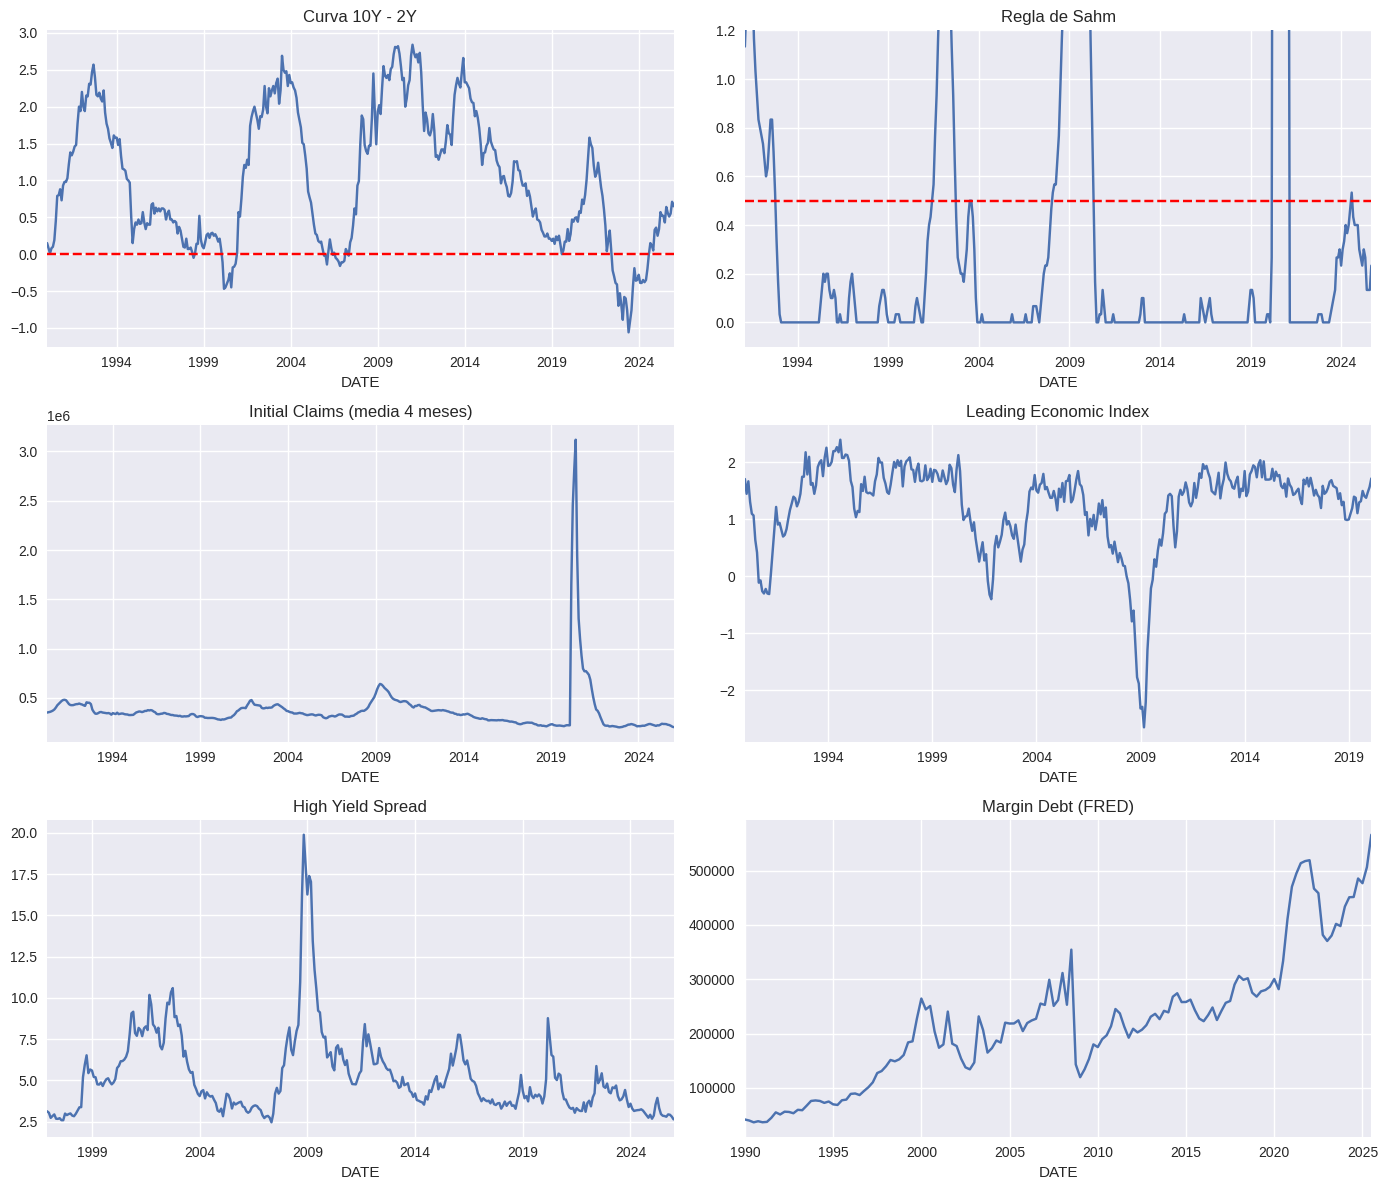


===== DIAGNÓSTICO MARGIN DEBT EXCEL =====
{'Fecha último dato': '01-11-2025', 'Variación 24 meses': '83.74%', 'Zona de alerta (>60%)': 'Sí'}


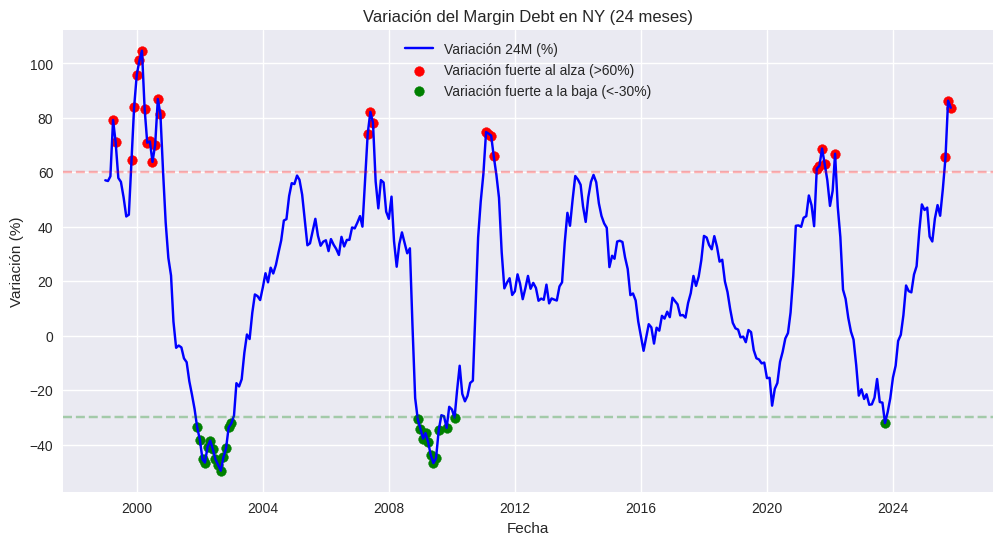

In [ ]:
# ============================================================
# RECESSION MONITOR - Clase unificada
# Combina:
# - Indicadores macro FRED
# - Análisis de Margin Debt desde Excel
# ============================================================

import os
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from datetime import datetime

plt.style.use("seaborn-v0_8")


class RecessionMonitor:

    def __init__(self, start="1990-01-01", data_dir="datos_monitor"):
        self.start = start
        self.end = datetime.today()
        self.data_dir = data_dir

        if not os.path.exists(self.data_dir):
            os.makedirs(self.data_dir)

        # Series FRED
        self.fred_series = {
            "DGS10": "10Y Treasury",
            "DGS2": "2Y Treasury",
            "ICSA": "Initial Jobless Claims",
            "UNRATE": "Unemployment Rate",
            "USSLIND": "Leading Economic Index",
            "BAMLH0A0HYM2": "High Yield Spread",
            "BOGZ1FL663067003Q": "Margin Debt FRED"
        }

        self.df_fred = None
        self.df_margin_excel = None

    # ---------------------------------------------------------
    # DESCARGA FRED
    # ---------------------------------------------------------
    def load_fred_data(self):
        print("Descargando datos FRED...")
        data = {}
        for code in self.fred_series.keys():
            print(f" - {code}")
            data[code] = pdr.DataReader(code, "fred", self.start, self.end)

        df = pd.concat(data.values(), axis=1)
        df.columns = self.fred_series.keys()

        # Unificar frecuencia mensual
        df = df.resample("ME").last()

        self.df_fred = df
        return df

    # ---------------------------------------------------------
    # CÁLCULO INDICADORES MACRO
    # ---------------------------------------------------------
    def compute_macro_indicators(self):

        df = self.df_fred.copy()

        # Curva de tipos
        df["Yield_Spread"] = df["DGS10"] - df["DGS2"]

        # Regla de Sahm
        unrate = df["UNRATE"]
        unrate_ma3 = unrate.rolling(3).mean()
        unrate_min12 = unrate_ma3.rolling(12).min()
        df["Sahm_Indicator"] = unrate_ma3 - unrate_min12

        # Claims media 4 meses
        df["Claims_4m"] = df["ICSA"].rolling(4).mean()

        # LEI variación 6 meses
        df["LEI_6m_change"] = df["USSLIND"].pct_change(6, fill_method=None) * 100

        # Margin Debt FRED YoY
        df["MarginDebt_YoY"] = df["BOGZ1FL663067003Q"].pct_change(12, fill_method=None) * 100

        self.df_fred = df
        return df

    # ---------------------------------------------------------
    # DIAGNÓSTICO MACRO
    # ---------------------------------------------------------
    def macro_diagnostic(self):

        df = self.df_fred
        latest = df.iloc[-1]

        signals = {
            "Curva invertida": latest["Yield_Spread"] < 0,
            "Regla de Sahm": latest["Sahm_Indicator"] > 0.5,
            "Claims en alza": df["Claims_4m"].pct_change(6, fill_method=None).iloc[-1] > 0.15,
            "LEI cayendo": latest["LEI_6m_change"] < -1,
            "High Yield Stress": latest["BAMLH0A0HYM2"] > 5,
            "Margin Debt caída YoY": latest["MarginDebt_YoY"] < -10
        }

        n = sum(signals.values())

        if n <= 1:
            diagnosis = "🟢 Condiciones normales. Sin señales claras de recesión."
        elif n <= 3:
            diagnosis = "🟠 Riesgo creciente. Varias señales de desaceleración."
        else:
            diagnosis = "🔴 Alta probabilidad de recesión según indicadores."

        return diagnosis, signals

    # ---------------------------------------------------------
    # GRÁFICOS MACRO
    # ---------------------------------------------------------
    def plot_macro_dashboard(self):

        df = self.df_fred

        fig, axes = plt.subplots(3, 2, figsize=(14, 12))
        axes = axes.flatten()

        df["Yield_Spread"].plot(ax=axes[0], title="Curva 10Y - 2Y")
        axes[0].axhline(0, color="red", linestyle="--")

        df["Sahm_Indicator"].dropna().plot(ax=axes[1], title="Regla de Sahm")
        axes[1].axhline(0.5, color="red", linestyle="--")
        axes[1].set_ylim(-0.1, 1.2)

        df["Claims_4m"].dropna().plot(ax=axes[2], title="Initial Claims (media 4 meses)")

        df["USSLIND"].dropna().plot(ax=axes[3], title="Leading Economic Index")

        df["BAMLH0A0HYM2"].dropna().plot(ax=axes[4], title="High Yield Spread")

        df["BOGZ1FL663067003Q"].dropna().plot(ax=axes[5], title="Margin Debt (FRED)")

        plt.tight_layout()
        plt.show()

    # ---------------------------------------------------------
    # CARGA EXCEL MARGIN DEBT NY (tu fichero)
    # ---------------------------------------------------------
    def load_margin_excel(self, file_path):

        df = pd.read_excel(file_path, header=1)
        df.columns = ['Year-Month', 'Debit Balances', 'Free Credit Cash', 'Free Credit Margin']
        df['Year-Month'] = pd.to_datetime(df['Year-Month'], format='%Y-%m')
        df = df.sort_values(by='Year-Month')

        df['24M Variation (%)'] = df['Debit Balances'].pct_change(periods=24, fill_method=None) * 100

        df = df.dropna(subset=['24M Variation (%)'])

        self.df_margin_excel = df
        return df

    # ---------------------------------------------------------
    # DIAGNÓSTICO MARGIN DEBT EXCEL
    # ---------------------------------------------------------
    def margin_excel_diagnostic(self):

        df = self.df_margin_excel
        last_variation = df['24M Variation (%)'].iloc[-1]
        last_date = df['Year-Month'].iloc[-1]

        diagnostic = {
            'Fecha último dato': last_date.strftime('%d-%m-%Y'),
            'Variación 24 meses': f"{last_variation:.2f}%",
            'Zona de alerta (>60%)': 'Sí' if last_variation > 60 else 'No'
        }

        return diagnostic

    # ---------------------------------------------------------
    # GRÁFICO MARGIN DEBT EXCEL
    # ---------------------------------------------------------

    def plot_margin_excel(self):
        df = self.df_margin_excel
        """Grafica la variación en 24 meses y la muestra."""
        plt.figure(figsize=(12, 6))
        plt.plot(df['Year-Month'], df['24M Variation (%)'], label='Variación 24M (%)', color='blue')

        strong_variation_up = df[df['24M Variation (%)'] > 60]
        strong_variation_down = df[df['24M Variation (%)'] < -30]

        plt.scatter(strong_variation_up['Year-Month'], strong_variation_up['24M Variation (%)'], color='red', label='Variación fuerte al alza (>60%)')
        plt.scatter(strong_variation_down['Year-Month'], strong_variation_down['24M Variation (%)'], color='green', label='Variación fuerte a la baja (<-30%)')

        plt.axhline(y=60, color='red', linestyle='--', alpha=0.3)
        plt.axhline(y=-30, color='green', linestyle='--', alpha=0.3)

        plt.title('Variación del Margin Debt en NY (24 meses)')
        plt.xlabel('Fecha')
        plt.ylabel('Variación (%)')
        plt.legend()
        plt.grid(True)

        # Guardar la gráfica
        #plt.savefig(f'{self.data_dir}/{save_path}', dpi=200, bbox_inches='tight')

        # Mostrar la gráfica
        plt.show()

monitor = RecessionMonitor()

# --- Parte FRED ---
monitor.load_fred_data()
monitor.compute_macro_indicators()

diagnosis, signals = monitor.macro_diagnostic()
print("\n===== DIAGNÓSTICO MACRO =====")
print(diagnosis)
for k,v in signals.items():
    print(f"{k}: {'Sí' if v else 'No'}")

monitor.plot_macro_dashboard()

# --- Parte Margin Debt Excel (opcional) ---
monitor.load_margin_excel("./Datos/margin-statistics.xlsx")
print("\n===== DIAGNÓSTICO MARGIN DEBT EXCEL =====")
print(monitor.margin_excel_diagnostic())

monitor.plot_margin_excel()


⚠️ Advertencia Importante

Los siguientes scripts y análisis son herramientas con fines exclusivamente educativos y de simulación. No constituyen en modo alguno un consejo de inversión, una recomendación para comprar o vender activos, ni una invitación a invertir en los valores o estrategias aquí mencionados.

    🤖 Agradecemos enormemente cualquier inconsistencia o error que nos ayudes a identificar.

    👨‍💼 Tu responsabilidad: La toma de decisiones de inversión recae exclusivamente en la persona que las ejecuta. Antes de tomar cualquier decisión, es fundamental que valides la información y los datos con fuentes profesionales independientes  y que consultes a un asesor financiero cualificado.

    💼 Gestión del riesgo: El uso de estas herramientas y la aplicación de las estrategias aquí presentadas es tu entera responsabilidad. Recuerda que el rendimiento pasado no asegura resultados futuros y que toda inversión conlleva riesgos.